# Splitting DF up based on year (<2019) and previous EDA/Modeling #

### Note ###

This work builds on work in other notebooks, notably Dillon's EDA_Tues notebook, Rashid's Notebook 4, and Seth's day 2 workbook

Once I get up to train_test_split, I only use new_df, but I keep the two halves of data consistent for future testing.

## Importing libraries and datasets ##

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", None)
import xgboost as xgb
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, plot_confusion_matrix, fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import warnings

In [2]:
df_ppl = pd.read_csv('data/People.csv')
df_cars = pd.read_csv('data/Vehicles.csv')
df_crashes = pd.read_csv('data/Crashes.csv')
warnings.filterwarnings('ignore')

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# making column names lowercase for ease of work
df_crashes.columns = df_crashes.columns.str.strip().str.lower()
df_cars.columns = df_cars.columns.str.strip().str.lower()
df_ppl.columns = df_ppl.columns.str.strip().str.lower()

In [4]:
# converting crash_date to datetime for future dataset split
df_crashes['crash_date'] = pd.to_datetime(df_crashes['crash_date'])

In [5]:
# creating our injury column, the future y-target
df_crashes['injury'] = df_crashes['injuries_total'] >= 1
df_crashes['injury']= df_crashes['injury'].astype(int)

In [6]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_record_id                541142 non-null  object        
 1   rd_no                          536550 non-null  object        
 2   crash_date_est_i               41029 non-null   object        
 3   crash_date                     541142 non-null  datetime64[ns]
 4   posted_speed_limit             541142 non-null  int64         
 5   traffic_control_device         541142 non-null  object        
 6   device_condition               541142 non-null  object        
 7   weather_condition              541142 non-null  object        
 8   lighting_condition             541142 non-null  object        
 9   first_crash_type               541142 non-null  object        
 10  trafficway_type                541142 non-null  object        
 11  

In [7]:
# ensuring that we only have the drivers from df_ppl
ppl_in_ppl_df = df_ppl[(df_ppl.person_type == 'DRIVER')]

### merging the three dataframes ###

In [8]:
m1 = pd.merge(df_cars, ppl_in_ppl_df, how='left', on=['crash_record_id'])

In [9]:
m2 = pd.merge(m1, df_crashes, how='left', on=['crash_record_id'])

In [10]:
full_df = m2.drop_duplicates(subset=['crash_record_id'], keep='first')

In [11]:
full_df['first_crash_type'].value_counts()

REAR END                        127020
PARKED MOTOR VEHICLE            125965
SIDESWIPE SAME DIRECTION         82738
TURNING                          75594
ANGLE                            57514
FIXED OBJECT                     25144
PEDESTRIAN                       12317
PEDALCYCLIST                      7993
SIDESWIPE OPPOSITE DIRECTION      7903
OTHER OBJECT                      5198
HEAD ON                           4666
REAR TO FRONT                     3593
REAR TO SIDE                      2197
OTHER NONCOLLISION                1750
REAR TO REAR                       808
ANIMAL                             377
OVERTURNED                         323
TRAIN                               33
Name: first_crash_type, dtype: int64

In [12]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541133 entries, 0 to 1960927
Columns: 150 entries, crash_unit_id to injury
dtypes: datetime64[ns](1), float64(25), int32(1), int64(7), object(116)
memory usage: 621.3+ MB


In [13]:
# picking our columns
columns = ['crash_date', 'crash_record_id', 'crash_date_x', 'latitude', 'longitude', 'injury', 'crash_month', 'crash_hour', 
           'street_name', 'damage', 'hit_and_run_i', 'roadway_surface_cond', 'road_defect',
          'weather_condition', 'crash_day_of_week', 'driver_action', 'exceed_speed_limit_i',
          'prim_contributory_cause', 'first_crash_type']

In [14]:
full_df = full_df[columns]

In [15]:
# creating 1 and 0 variables for whether the accident occured during rush_hour
# rush_hour in Chicago is defined as: Monday-Friday, 7-9am and 3-7pm
# per the website the data was pulled from, Sunday = 1, so we need the days between 2-6
def rush_hour(time):
    if ((time >= 7 and time <= 9) or (time >= 15 and time <= 18)):
        return 1
    else:
        return 0
def rush_hour_day(day):
    if (day >= 2 and day <= 6):
        return 1
    else:
        return 0

full_df['rush_hour'] = (full_df['crash_hour'].apply(rush_hour) & full_df['crash_day_of_week'].apply(rush_hour_day))

In [16]:
full_df = full_df[(full_df['weather_condition'] != 'UNKNOWN') & (full_df['weather_condition'] != 'OTHER')]

In [17]:
# creating a dictionary of primary causes of an accident, simplified
cause_dict = {'FAILING TO YIELD RIGHT-OF-WAY': 'Breaking Rules of Road',
              'IMPROPER LANE USAGE': 'Breaking Rules of Road',
             'DISREGARDING TRAFFIC SIGNALS' : 'Breaking Rules of Road',
             'IMPROPER TURNING/NO SIGNAL': 'Breaking Rules of Road',
              'DISREGARDING STOP SIGN' : 'Breaking Rules of Road',
             'DISREGARDING OTHER TRAFFIC SIGNS': 'Breaking Rules of Road',
             'DISREGARDING ROAD MARKINGS': 'Breaking Rules of Road',
             'DISREGARDING YIELD SIGN': 'Breaking Rules of Road',
             'PASSING STOPPED SCHOOL BUS': 'Breaking Rules of Road',
             'TURNING RIGHT ON RED': 'Breaking Rules of Road',
              'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Speed Related',
              'EXCEEDING AUTHORIZED SPEED LIMIT': 'Speed Related',
              'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Speed Related',
              'FOLLOWING TOO CLOSELY': 'Reckless/Poor Driving',
              'IMPROPER OVERTAKING/PASSING': 'Reckless/Poor Driving',
              'IMPROPER BACKING': 'Reckless/Poor Driving',
              'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Reckless/Poor Driving',
              'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Reckless/Poor Driving',
              'DRIVING ON WRONG SIDE/WRONG WAY': 'Reckless/Poor Driving',
              'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Drug/Alcohol Related',
              'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Drug/Alcohol Related',
              'PHYSICAL CONDITION OF DRIVER': 'Reckless/Poor Driving',
              'DISTRACTION - FROM INSIDE VEHICLE':'Distracted Driving',
              'CELL PHONE USE OTHER THAN TEXTING':'Distracted Driving',
              'TEXTING':'Distracted Driving',
              'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':'Distracted Driving',
              'WEATHER':"Outside World/Out of Drivers Control",
              'EQUIPMENT - VEHICLE CONDITION':"Outside World/Out of Drivers Control",
              'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)':"Outside World/Out of Drivers Control",
              'DISTRACTION - FROM OUTSIDE VEHICLE':"Outside World/Out of Drivers Control",
              'ROAD ENGINEERING/SURFACE/MARKING DEFECTS':"Outside World/Out of Drivers Control",
              'ROAD CONSTRUCTION/MAINTENANCE':"Outside World/Out of Drivers Control",
              'ANIMAL':"Outside World/Out of Drivers Control",
              'EQUIPMENT - VEHICLE CONDITION': "Outside World/Out of Drivers Control",
              'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST':"Outside World/Out of Drivers Control",
              'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Drivers Control",
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Drivers Control",
              'UNABLE TO DETERMINE': 'Other/Unknown',
              'NOT APPLICABLE': 'Other/Unknown',
              'OBSTRUCTED CROSSWALKS': 'Other/Unknown',
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown',
              'RELATED TO BUS STOP': 'Other/Unknown',
             'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown'}

In [18]:
weather_dict = {'CLEAR': 'neutral',
                'RAIN': 'bad',
                'SNOW': 'bad',
                'CLOUDY/OVERCAST': 'neutral',
                'FOG/SMOKE/HAZE': 'vision_obstruction',
                'SLEET/HAIL': 'extreme',
                'FREEZING RAIN/DRIZZLE': 'extreme',
                'BLOWING SNOW': 'vision_obstruction',
                'SEVERE CROSS WIND GATE': 'extreme',
                'BLOWING SAND, SOIL, DIRT': 'vision_obstruction'
}

In [19]:
full_df['simple_reason'] = full_df['prim_contributory_cause'].map(cause_dict)
full_df['weather_condition'] = full_df['weather_condition'].map(weather_dict)

In [20]:
full_df = pd.get_dummies(full_df, columns=['simple_reason', 'weather_condition', 'first_crash_type'])

In [21]:
# 1s and 0s for road_defects
def defect(road):
    if road == 'NO DEFECTS':
        return 0
    else:
        return 1
    
full_df['road_defect'] = (full_df['road_defect'].apply(defect))

In [22]:
# got rid of any "unknown" road_defects
full_df = full_df[full_df.road_defect != 'UNKNOWN']

In [23]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515617 entries, 0 to 1960927
Data columns (total 47 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   crash_date                                          515617 non-null  datetime64[ns]
 1   crash_record_id                                     515617 non-null  object        
 2   crash_date_x                                        515617 non-null  object        
 3   latitude                                            512594 non-null  float64       
 4   longitude                                           512594 non-null  float64       
 5   injury                                              515617 non-null  int32         
 6   crash_month                                         515617 non-null  int64         
 7   crash_hour                                          515617 non-null  int64        

In [24]:
full_df2 = full_df.drop(labels = ['crash_record_id','crash_date_x','latitude','longitude', 'street_name',
                       'damage','exceed_speed_limit_i', 'prim_contributory_cause', 'hit_and_run_i', 'crash_hour',
                        'crash_month', 'roadway_surface_cond', 'crash_day_of_week', 'driver_action', 'first_crash_type_OTHER NONCOLLISION', 'simple_reason_Other/Unknown'], axis=1)

#### Splitting df into everything before Jan 01, 2019 and from that point until the data was pulled (Sep 12, 2021) ####

In [25]:
old_df = (full_df2[full_df2['crash_date'] < '2018-12-31 12:59:59'])
new_df = (full_df2[full_df2['crash_date'] >= '2019-01-01 00:00:00'])

In [26]:
print(old_df.info())
print("""
      """)
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244633 entries, 58 to 1784402
Data columns (total 31 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   crash_date                                          244633 non-null  datetime64[ns]
 1   injury                                              244633 non-null  int32         
 2   road_defect                                         244633 non-null  int64         
 3   rush_hour                                           244633 non-null  int64         
 4   simple_reason_Breaking Rules of Road                244633 non-null  uint8         
 5   simple_reason_Distracted Driving                    244633 non-null  uint8         
 6   simple_reason_Drug/Alcohol Related                  244633 non-null  uint8         
 7   simple_reason_Outside World/Out of Drivers Control  244633 non-null  uint8       

#### From here, we will just use the new_df ####

In [27]:
corr = new_df.corr()
corr

,injury,road_defect,rush_hour,simple_reason_Breaking Rules of Road,simple_reason_Distracted Driving,simple_reason_Drug/Alcohol Related,simple_reason_Outside World/Out of Drivers Control,simple_reason_Reckless/Poor Driving,simple_reason_Speed Related,weather_condition_bad,weather_condition_extreme,weather_condition_neutral,weather_condition_vision_obstruction,first_crash_type_ANGLE,first_crash_type_ANIMAL,first_crash_type_FIXED OBJECT,first_crash_type_HEAD ON,first_crash_type_OTHER OBJECT,first_crash_type_OVERTURNED,first_crash_type_PARKED MOTOR VEHICLE,first_crash_type_PEDALCYCLIST,first_crash_type_PEDESTRIAN,first_crash_type_REAR END,first_crash_type_REAR TO FRONT,first_crash_type_REAR TO REAR,first_crash_type_REAR TO SIDE,first_crash_type_SIDESWIPE OPPOSITE DIRECTION,first_crash_type_SIDESWIPE SAME DIRECTION,first_crash_type_TRAIN,first_crash_type_TURNING
injury,1.000000,-0.012149,-0.018033,0.115907,0.017899,0.034027,0.009621,-0.053874,0.058918,0.005878,0.003027,-0.006770,0.003634,0.089629,-0.007430,0.019771,0.051919,-0.008568,0.022590,-0.167537,0.198509,0.319799,-0.009815,-0.033424,-0.020606,-0.020132,-0.010606,-0.108203,0.006198,0.027996
road_defect,-0.012149,1.000000,-0.011841,-0.050205,-0.012749,-0.009163,0.042956,-0.027141,-0.010782,0.049685,0.007701,-0.051286,0.008924,-0.010268,-0.000006,0.019721,-0.000376,0.047992,0.002624,-0.009270,-0.004121,0.001817,0.003581,0.002424,0.001081,0.005796,0.001166,-0.004776,0.000562,-0.017775
rush_hour,-0.018033,-0.011841,1.000000,0.019585,-0.010021,-0.037309,-0.002261,0.026168,-0.014715,-0.016965,-0.004885,0.017542,0.000124,0.001029,-0.000856,-0.053564,-0.011700,-0.016106,-0.007278,-0.079663,0.019857,0.007996,0.053029,-0.004122,-0.003769,-0.004036,-0.001567,0.044891,-0.003885,0.023583
simple_reason_Breaking Rules of Road,0.115907,-0.050205,0.019585,1.000000,-0.053563,-0.045814,-0.112029,-0.298800,-0.122741,-0.017828,-0.002369,0.018642,-0.005773,0.276607,-0.010257,-0.096013,-0.008816,-0.044356,-0.010310,-0.220413,0.046316,0.048185,-0.245013,-0.047169,-0.021644,-0.004342,-0.011944,0.067263,0.004841,0.308568
simple_reason_Distracted Driving,0.017899,-0.012749,-0.010021,-0.053563,1.000000,-0.008806,-0.021533,-0.057433,-0.023592,-0.013387,-0.003469,0.013541,0.001986,-0.023233,-0.002786,0.011270,0.007376,-0.002682,0.002697,0.013824,-0.004472,-0.004727,0.052460,-0.007550,-0.004104,-0.004823,-0.000678,-0.026431,-0.000935,-0.030935
simple_reason_Drug/Alcohol Related,0.034027,-0.009163,-0.037309,-0.045814,-0.008806,1.000000,-0.018418,-0.049124,-0.020179,-0.001047,0.001356,0.000840,-0.000508,-0.017915,-0.002383,0.040752,0.020846,0.003484,0.003997,0.041917,-0.007817,-0.005293,-0.010956,-0.004849,-0.004680,-0.007212,0.007703,-0.023019,-0.000800,-0.024089
simple_reason_Outside World/Out of Drivers Control,0.009621,0.042956,-0.002261,-0.112029,-0.021533,-0.018418,1.000000,-0.120123,-0.049344,0.160554,0.038172,-0.167803,0.025805,-0.019263,0.073715,0.129497,0.009570,0.079265,0.014443,-0.002871,-0.003693,0.010857,-0.009580,-0.011848,-0.008061,-0.010147,0.000506,-0.051096,0.001991,-0.041197
simple_reason_Reckless/Poor Driving,-0.053874,-0.027141,0.026168,-0.298800,-0.057433,-0.049124,-0.120123,1.000000,-0.131608,-0.027662,-0.009620,0.029469,-0.004426,-0.133595,-0.015229,-0.035525,0.014072,-0.026678,-0.004157,-0.046585,-0.036326,-0.058787,0.245813,0.094550,0.022518,0.035734,0.008667,0.027711,-0.002413,-0.118233
simple_reason_Speed Related,0.058918,-0.010782,-0.014715,-0.122741,-0.023592,-0.020179,-0.049344,-0.131608,1.000000,0.020234,0.002671,-0.020312,-0.000384,-0.029851,-0.005164,0.017336,0.000814,-0.004962,0.001143,-0.029605,-0.011859,-0.005007,0.143873,-0.019306,-0.009424,-0.014729,-0.006397,-0.057790,0.003307,-0.037907
weather_condition_bad,0.005878,0.049685,-0.016965,-0.017828,-0.013387,-0.001047,0.160554,-0.027662,0.020234,1.000000,-0.024269,-0.975478,-0.016000,0.005922,-0.003744,0.035331,0.009076,0.007436,0.003036,-0.019935,-0.022526,0.014755,0.026043,-0.007264,-0.007438,-0.008611,0.004081,-0.0304

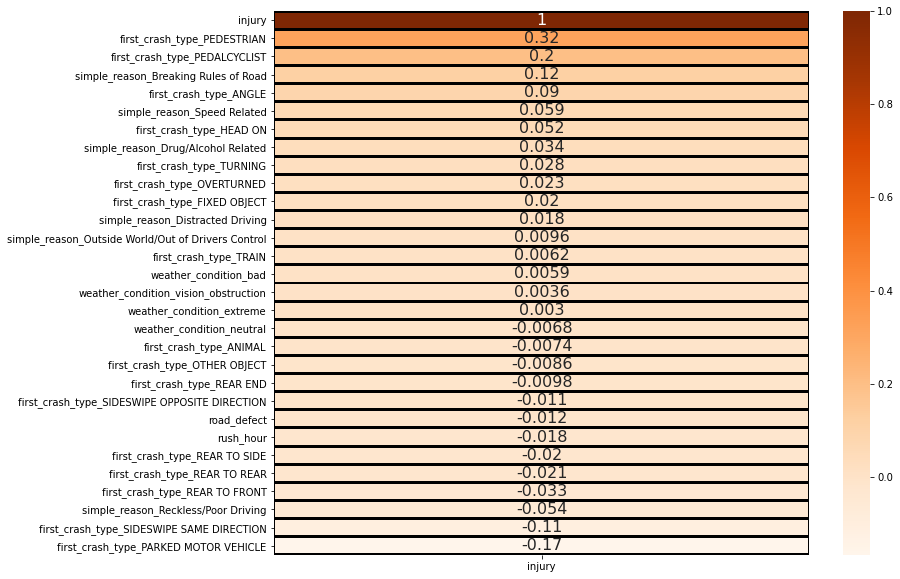

In [28]:
x = corr[['injury']]
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(x.sort_values(by=['injury'], ascending=0),
           annot=True,
           cmap='Oranges',
           annot_kws={'fontsize': 16},
           linewidth=2,
           linecolor='black',
           xticklabels = ['injury']);

In [29]:
X = new_df.drop(labels = ['injury', 'crash_date'], axis=1)
y = new_df['injury']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

### Testing pipelines, initial model ###

#### Best Model Pipeline ####

In [31]:
rand = RandomForestClassifier(random_state=42)
cross_val_score(rand, X_train, y_train, cv=10).mean()

KeyboardInterrupt: 

In [ ]:
pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                       ('pca1',PCA(n_components=2)),
                       ('lr_classifier', LogisticRegression(random_state=42))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('pca2',PCA(n_components=2)),
                        ('dt_classifier', DecisionTreeClassifier())
])

pipeline_rf = Pipeline([('scalar3', StandardScaler()),
                       ('pca3', PCA(n_components=2)),
                       ('rf_classifier', RandomForestClassifier())])

In [ ]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf]

In [ ]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [ ]:
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [ ]:
for i, model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i], model.score(X_test, y_test)))

In [ ]:
for i, model in enumerate(pipelines):
    if model.score(X_test, y_test) > best_accuracy:
        best_accuracy = model.score(X_test, y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy: {}'.format(pipe_dict[best_classifier]))

#### Random Forest Classifier 1 ####

In [ ]:
rand = RandomForestClassifier(random_state=42)
rand.fit(X_train, y_train)
plot_confusion_matrix(rand, X_test, y_test);

In [ ]:
# SMOTE that data!

# standardizing the data
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Default hyperparameters are in use here

y_pred = rand.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

Solid Scores. Let's go further with some different hyperparameters.

#### Random Forest Classifier 2 ####

In [ ]:
grid_values = {'max_features' : ['log2']}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

The original max_feature used sqrt (auto). That's the way to go for now...

#### Random Forest Classifier 3 ####

In [ ]:
grid_values = {'criterion' : ['entropy']}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

entropy as critereon has presented a slightly better f1 score!

#### Random Forest Classifier 4 ####

In [ ]:
grid_values = {'n_estimators' : [10], 'criterion' : ['entropy']}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

even better!

#### Random Forest Classifier 5 ####

In [ ]:
grid_values = {'n_estimators' : [10], 'criterion' : ['entropy'], 'max_leaf_nodes' : [2]}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

#### Logistic Regression 1 ####

In [ ]:
logreg = LogisticRegression(random_state=42)

grid_values = {'penalty': ['l2'],'C':[.0001,.001,.01,.1,1]}

grid = GridSearchCV(logreg, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("CVS:", -(baseline_cv.mean()))

#### Gaussian Naive Bayes 1 ####

In [ ]:
gnb = GaussianNB()

gnb = gnb.fit(X_train, y_train)

grid_values = {}

grid = GridSearchCV(gnb, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))